In [17]:
import pandas as pd
import numpy as np
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Sequential

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
df.shape

(112475, 12)

### Preprocess dates

In [19]:
# Extract features from the date
df['day_of_week'] = pd.to_datetime(df['dteday']).dt.dayofweek
df['day'] = pd.to_datetime(df['dteday']).dt.day
df['month'] = pd.to_datetime(df['dteday']).dt.month

# One-hot encode the features
encoder = OneHotEncoder()
day_of_week_encoded = encoder.fit_transform(df[['day_of_week']]).toarray()
day_encoded = encoder.fit_transform(df[['day']]).toarray()
month_encoded = encoder.fit_transform(df[['month']]).toarray()

# Concatenate the encoded features with the original dataframe
df_encoded = pd.concat([df, pd.DataFrame(day_of_week_encoded, columns=[f'day_of_week_{i}' for i in range(7)])], axis=1)
df_encoded = pd.concat([df_encoded, pd.DataFrame(day_encoded, columns=[f'day_{i}' for i in range(1, 32)])], axis=1)
df_encoded = pd.concat([df_encoded, pd.DataFrame(month_encoded, columns=[f'month_{i}' for i in range(1, 13)])], axis=1)

# Drop the original features
df_encoded.drop(['dteday', 'day_of_week', 'day', 'month'], axis=1, inplace=True)

print(df_encoded.columns)

Index(['hr', 'casual', 'registered', 'temp_c', 'feels_like_c', 'hum',
       'windspeed', 'weathersit', 'season', 'holiday', 'workingday',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')


### Create target column

In [20]:
df_encoded['total'] = df['casual'] + df['registered']
df_encoded.drop(['casual', 'registered'], inplace=True, axis=1)

df_encoded.head()

,hr,temp_c,feels_like_c,hum,windspeed,weathersit,season,holiday,workingday,day_of_week_0,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,total
0,0.0,3.0,3.0,0.7957,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16
1,1.0,1.7,1.7,0.8272,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,2.0,1.9,1.9,0.8157,1.1,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31
3,3.0,2.5,2.5,0.7831,0.8,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
4,4.0,2.0,2.0,0.8075,1.1,1,1,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [21]:
y = df_encoded['total']
X = df_encoded.drop('total', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [22]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform data
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

### Make the model

In [23]:
# Tried:
# Model 1: 35000 MSE
# Dense(64, activation='sigmoid', input_dim=num_features),
# Dense(128, activation='sigmoid'),
# Dense(64, activation='sigmoid'),
# Dense(1, activation='swish')

# Model 2: 12719 MSE,
# Dense(128, activation='relu', input_dim=num_features),
# Dense(64, activation='relu'),
# Dense(32, activation='relu'),
# Dense(1)

# Model 3: 16359 MSE, 17664 MSE
# Dense(128, activation='relu', input_dim=num_features),
# BatchNormalization(),
# Dense(64, activation='relu'),
# BatchNormalization(),
# Dense(32, activation='relu'),
# BatchNormalization(),
# Dense(1)

# Model 4: Model MSE: 26334  Validation MSE: 157
# Dense(128, activation='relu', input_dim=num_features),
# Dropout(.4),
# Dense(64, activation='relu'),
# Dropout(.4),
# Dense(32, activation='relu'),
# Dense(1)

num_features = len(X_train[0])

# model.add(Dropout(.5))

model = Sequential([
  Dense(128, activation='relu', input_dim=num_features),
  Dropout(.4),
  Dense(64, activation='relu'),
  Dropout(.4),
  Dense(32, activation='relu'),
  Dense(1)
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           7,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=15, mode='min')

history = model.fit(X_train, y_train, epochs=500, validation_split=.35, batch_size=20, callbacks=[early_stop], shuffle=False)
hist = pd.DataFrame(history.history)

Epoch 1/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 120613.1641 - mae: 250.5274 - val_loss: 77510.5859 - val_mae: 200.8637
Epoch 2/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 78953.7500 - mae: 203.2512 - val_loss: 71570.1094 - val_mae: 189.2666
Epoch 3/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 72846.2891 - mae: 190.6653 - val_loss: 63964.6641 - val_mae: 169.2274
Epoch 4/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 66247.2969 - mae: 175.7610 - val_loss: 58363.4414 - val_mae: 156.2882
Epoch 5/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 63209.4492 - mae: 168.7027 - val_loss: 55561.7578 - val_mae: 150.7255
Epoch 6/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 59755.8906 - mae: 162.9350 - val_loss: 54344.1289 - val_mae: 148.2213
Epoch 7/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 58863.7695 - mae: 160.3832 - val_loss: 52716.0586 - val_mae: 146.0434
Epoch 8/500
2925/2925 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 

### Plot loss

In [25]:
#px.line(hist, x='index', y='mse')

### Predict values

In [26]:
predictions = np.round(model.predict(X_test), 1)
predictions

703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[ 337.4],
       [1021. ],
       [ 252.4],
       ...,
       [ 375.2],
       [ 401.3],
       [  79.2]], dtype=float32)

In [27]:
result = mean_squared_error(y_test, predictions, squared=False)
result

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


156.86928722621226

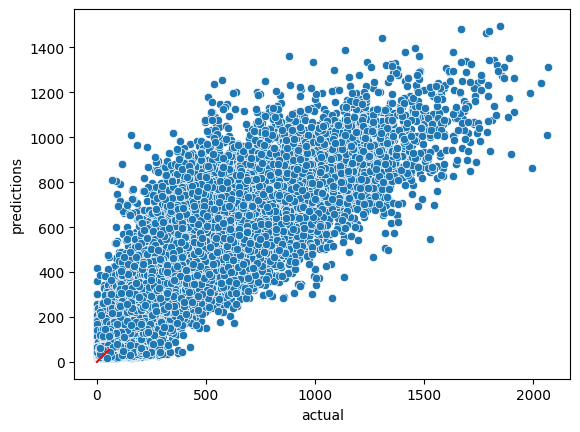

In [29]:
pred = pd.DataFrame(predictions,columns=['predictions'])
pred
pred['actual'] = y_test.tolist()
pred

pred['difference'] = pred['actual'] - pred['predictions']
pred

import seaborn as sns
import matplotlib.pyplot as plt

xlims =(0,55)
ax = sns.scatterplot(data=pred,x='actual',y='predictions')
ax.plot(xlims,xlims, color='r')
plt.show()